# Goal
Explore and try to find a model to describe energy sums of Calorimeter data. Find a reason why the "noise" seems increase with sum value (left image):<br>

<table>
    <tr>
        <td><img src="mod2.png" width="400"></td>
        <td><img src="mod1.png" width="400"></td>
        <td><img src="mod3.png" width="400"></td>
    </tr>
</table>

In [2]:
import numpy as np
np.random.seed(42)
import matplotlib.pyplot as plt
from functools import lru_cache
from bitstring import BitArray

# Encoding and decoding functions
We assume that the calorimeter data that we get handed is already encoded into values between 0 and 127, which happens on a very low level from the true ADC counts 0 up to $\sim$230000. Here, we want to model this encoding process from *true* ADC values which we think of as representing the *true* energy which a particle has deposited in the detector. Thereby, we are particularly interested in how much noise this encoding produces in the data. 

**Note:** There is also an inherent fluctuation in the energy deposition which increases with particle energy. In this simple study we ignore this type of fluctuation and only focus on the effect the encoding has on the data.

In [4]:
exp_bits = 4
man_bits = 3
max_TCval = (2**man_bits - 1) * 2**(2**exp_bits - 1)
max_TCcode = 2**(man_bits+exp_bits) - 1

@np.vectorize
@lru_cache(128)
def encode(val):
    assert(val >= 0)
    val = np.int32(val)
    bit_len = val.item().bit_length()
    if bit_len <= man_bits:
        return val # special case: return mantissa if value in this range
    if val >= max_TCval:
        return max_TCcode # clip overflow
    
    exp = bit_len - man_bits
    man = val >> exp - 1
    
    ebits = BitArray(uint=exp, length=exp_bits)
    mbits = BitArray(uint=man, length=man.item().bit_length())[1:]
    
    return (ebits+mbits).uint

@np.vectorize
@lru_cache(128)
def decode(code):
    code = int(code)
    assert(code.bit_length() <= man_bits+exp_bits)
    assert(code >= 0)
    
    bits = BitArray(uint=code, length=man_bits+exp_bits)
    ebits = bits[:exp_bits]
    mbits = bits[exp_bits:]
    
    if ebits.uint == 0:
        return mbits.uint
    else:
        return (BitArray('0b1') + mbits).uint << (ebits.uint - 1)
    
import ROC
E_MeV_per_ADC = (ROC.E_keV_per_MIP * 1e-3) / ROC.ADC_per_MIP

# ADC values and codes
The ADC value corresponding to a code scales exponentially. In other words, for small values (up to ADC value 16) the code is identical. After that, the codes start to correspond to increasing ADC values. We can illustrate this by plotting the decoding function over its full range:

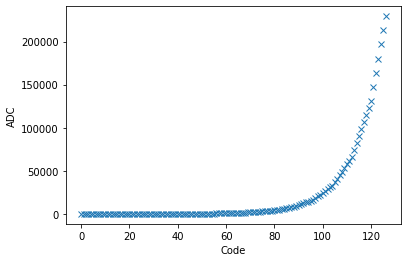

In [40]:
plt.plot(decode(range(max_TCcode)), 'x');
plt.xlabel('Code');
plt.ylabel('ADC');

Conversely, we can plot the number of unique ADC values corresponding to a code by iterating over the full range of possible ADC values and encoding it. We see that larger codes correspond to exponentially more ADC values.

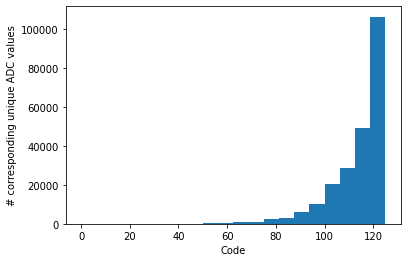

In [41]:
adc = np.array(range(max_TCval))
codes = encode(adc)
plt.hist(codes, bins=20);
plt.xlabel('Code');
plt.ylabel('# corresponding unique ADC values');

When we now decode these codes again, the decoding function maps each code word back to a single ADC value. Further, we can also see that the range between codes does not increase exponentially but linearly in groups of 8 neighboring codes and that the encoding function maps ADC values always to the **next lowest code**, by which the encoded-decoded value is strictly **below** the original value, thus in all cases we underestimate the true value when we only look at encoded-decoded values.

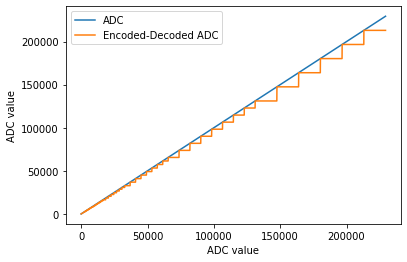

In [42]:
decodes = decode(codes)
plt.plot(adc, adc, label='ADC');
plt.plot(adc, decodes, label='Encoded-Decoded ADC');
plt.xlabel('ADC value');
plt.ylabel('ADC value');
plt.legend();

Plotting the residuals between encoded-decoded ADC values (decoded codes) and true ADC values we see that for some ADC values we will have a larger error than for others. In particular those value which are at the upper end between two codes for which the corresponding ADC value is mapped to the next (far away) lowest code. We can also see that this is only a problem for large values, as the residuals increase step-wise (in groups of 8 code words) with ADC values.

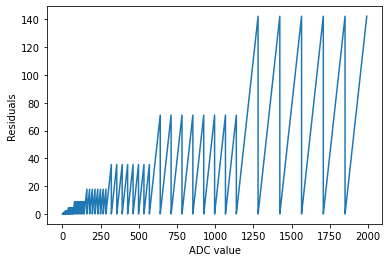

In [44]:
decodes = decode(codes)

diff = adc-decodes
plt.plot(adc*E_MeV_per_ADC, diff*E_MeV_per_ADC);
plt.xlabel('ADC value');
plt.ylabel('Residuals');

# Sums of ADC values
Now, for calorimeter data we know that particles cause showers, i.e. bright "lines" in otherwise dark regions. Looking at a single (EM) shower in one slice of the detector we have a bright spots (of high ADC values) surrounded by otherwise low ADC values (not exactly 0 due to noise). If we are interested in the total energy which was deposited in this detector slice, all we need to do is sum up the pixel values. For the sum it actually doesn't matter where these pixel values are located in the image, only the distribution matters. We can try a Beta-function with large probability for sampling low pixel values and increasingly lower probability for larger values.

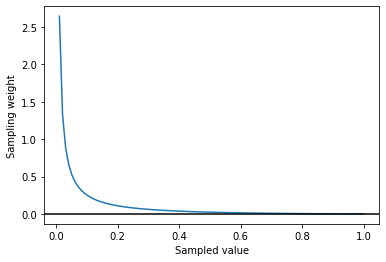

In [125]:
from scipy.stats import beta

x = np.linspace(0,1,100)
a,b = 0.03,2.4
rv = beta(a,b)

plt.plot(x, rv.pdf(x));
plt.axhline(0, c='k');
plt.xlabel('Sampled value');
plt.ylabel('Sampling weight');

As we generate module *images* of $7\times 7$ pixel values, we find that most of those are actually all zero. We choose this to be the case for 98% of all modules. Furthermore, during encoding an ADC threshold is applied of code value 5. As low ADC values (below 16) are mapped 1-to-1 to codes, we can apply this threshold also directly on the ADC data per cell/pixel.

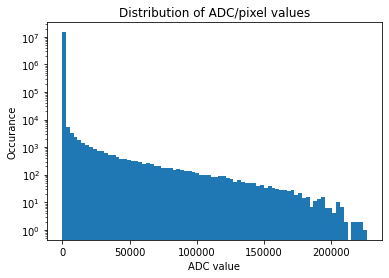

In [121]:
a,b = 0.03,2.4
N = 300_000
W = 7

r = np.zeros((N,W,W))
k = N // 50
r[:k] = np.random.beta(a,b,size=(k,W,W))
adcs = (r*max_TCval).astype(int)

adcs[adcs < 5] = 0 # ADC threshold

plt.title('Distribution of ADC/pixel values');
plt.hist(adcs.flatten(), bins=80);
plt.yscale('log');
plt.xlabel('ADC value');
plt.ylabel('Occurance');

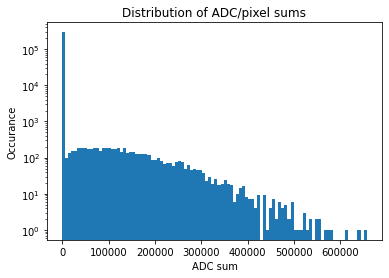

In [122]:
adc_sums = np.sum(adcs, axis=(1,2))
plt.title('Distribution of ADC/pixel sums');
plt.hist(adc_sums, bins=100);
plt.yscale('log');
plt.xlabel('ADC sum');
plt.ylabel('Occurance');

We can take a few example modules which are produced from this distribution. As we have lots of "empty" samples we only select those that have a pixel sum which is larger than 0.

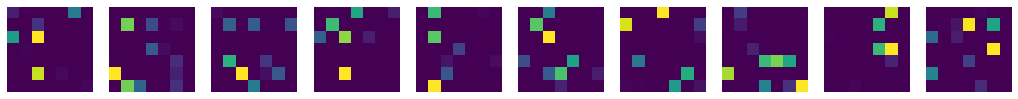

In [124]:
n_expls = 10

fig,ax = plt.subplots(1,n_expls, figsize=(18,4))
for i,idx in enumerate(np.argsort(adc_sums)[-n_expls:]):
    ax[i].imshow(adcs[idx]); 
    ax[i].axis('off');

Furthermore, we can show that sampling from this distribution, then encoding (and afterwards decoding) generates similar plots to what we get from the real (simulated) detector data.

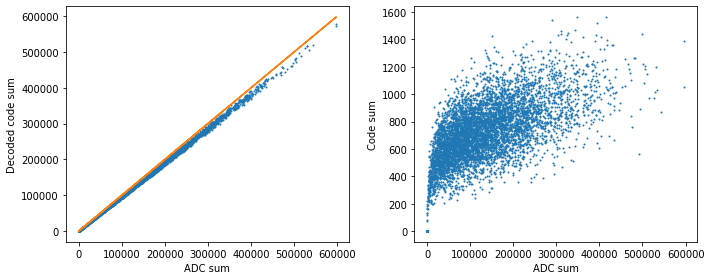

In [111]:
codes = encode(adcs)
decodes = decode(codes)
code_sums = np.sum(codes, axis=(2,1))
decode_sums = np.sum(decodes, axis=(2,1))

fig, ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(adc_sums, decode_sums, 'o', markersize=1);
ax[0].plot(adc_sums, adc_sums);
ax[0].set_ylabel('Decoded code sum')
ax[0].set_xlabel('ADC sum')
ax[1].plot(adc_sums, code_sums, 'o', markersize=1);
ax[1].set_ylabel('Code sum')
ax[1].set_xlabel('ADC sum');
plt.tight_layout()

Let's take a look at the residuals of the sums. For this we only want to consider the images which actually have content. For "empty" images we know that the residuals will be 0.

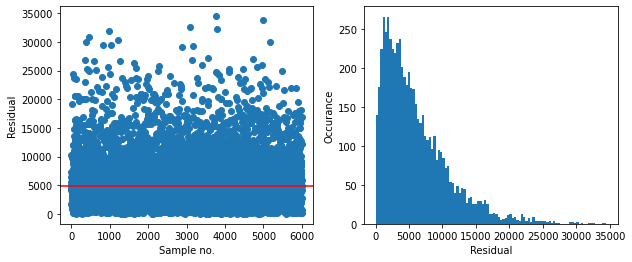

In [117]:
res = adc_sums[:k] - decode_sums[:k]
std = np.std(res)

fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(res,'o');
ax[0].axhline(std, c='red');
ax[0].set_ylabel('Residual');
ax[0].set_xlabel('Sample no.');

ax[1].hist(res, bins=100);
ax[1].set_ylabel('Occurance');
ax[1].set_xlabel('Residual');

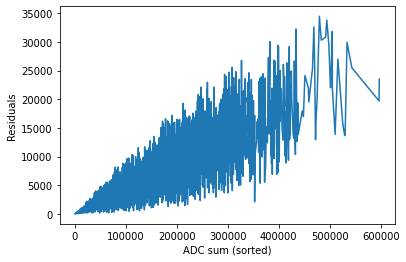

In [119]:
ids = np.argsort(adc_sums[:k])
diff = adc_sums[:k][ids] - decode_sums[:k][ids]
plt.plot(adc_sums[:k][ids], diff);
plt.xlabel('ADC sum (sorted)');
plt.ylabel('Residuals');

We can see the same increasing trend as for the single pixel values, only here we see that for larger sums we virtually never reach a residual of 0. This is because to "hit" the "good" pixel values for which we add nothing to the residuals becomes more and more unlikely the more larger pixel values we have in an image. Also the "stair-case" like progression begins to wash out as many combinations of pixel values are possible which correspond to the same ADC sum, but can have vastly different decode sums, which becomes more and more true for sums containing larger pixel values.

# Result
We see that:
1. Calorimeter pixel sums can be roughly modeled by a Beta distribution and many "empty" images.
2. Due to 4E3M encoding larger pixel values have larger amounts of variation (noise). 
3. The increase in fluctuation of ADC sums is caused by more decode value configurations corresponding to the same (true) ADC/pixel sum.